In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# Utility-тетрадка которая учит ансамбль

In [18]:
#обработаем данные

data = pd.DataFrame.from_csv("./evaluation.private.csv")

y = data['burned'].values
w = data['weights'].values


# Прочитаем решения участников
в обычном формате

Пока мя не знаю, как именно они хранятся, предположим, что хранятся в файлах с именами участников

In [48]:
import os


metafeatures = {}
subm_names = os.listdir("./submissions")
for subm_name in subm_names:
    subm = pd.DataFrame.from_csv(os.path.join("submissions/",subm_name),index_col=None)
    
    metafeatures[subm_name] = subm.Y_prob
    
    
    

In [49]:
X = pd.DataFrame(metafeatures)

in_test = data.source.values == 'holdoff'

Xtr = X[~in_test]
Xts = X[in_test]
Ytr = y[~in_test]
Yts = y[in_test]
Wtr = w[~in_test]
Wts = w[in_test]

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import ExtraTreesClassifier

In [51]:
Xtr.shape,Ytr.shape,Wtr.shape

((678013, 13), (678013,), (678013,))

In [52]:
model = ExtraTreesClassifier(n_estimators=10,n_jobs=-1,min_samples_leaf=30).fit(Xtr,Ytr,sample_weight=Wtr)

train: 	 AUC = 0.72372 	 Accuracy = 0.84903 	 Precision = 0.84903 	 Recall = 1.00000
val: 	 AUC = 0.63237 	 Accuracy = 0.84440 	 Precision = 0.84443 	 Recall = 0.99995


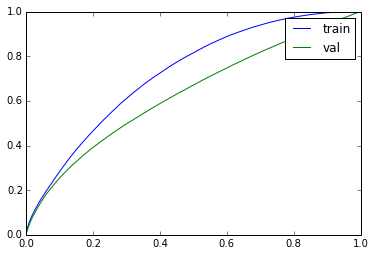

In [56]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_curve


for source_i, Xi,Yi,Wi in [
                            ["train",Xtr,Ytr,Wtr],
                            ["val",Xts,Yts,Wts]
                                ]:
    
    # Предскажем вероятность сгорания
    Yi_pred_proba = model.predict_proba(Xi)[:,1]
    
    #Поделим предсказание на сгоревшие и не сгоревшие по порогу (0.5)
    thr = 0.5
    Yi_pred_class = Yi_pred_proba>thr

    auc = roc_auc_score(Yi,Yi_pred_proba,sample_weight = Wi)
    acc = accuracy_score(Yi,Yi_pred_class,sample_weight = Wi)
    prc = precision_score(Yi,Yi_pred_class,sample_weight = Wi)
    rcl = recall_score(Yi,Yi_pred_class,sample_weight = Wi)
    
    print '%s: \t AUC = %.5f \t Accuracy = %.5f \t Precision = %.5f \t Recall = %.5f'%(source_i, auc, acc,prc,rcl)
    
    fpr,tpr,_ = roc_curve(Yi,Yi_pred_proba,sample_weight=Wi)
    
    plt.plot(fpr,tpr,label = source_i)
    
plt.legend()


In [60]:
def plot_forest_feature_importances(rf,feature_names):
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %s (%f)" % (f + 1, feature_names[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    
    plt.yscale("log")
    plt.show()
    
    return dict(zip(feature_names,importances))

Feature ranking:
1. 0.csv (0.111187)
2. 1.csv (0.103207)
3. 10.csv (0.102475)
4. 2.csv (0.102473)
5. 3.csv (0.093154)
6. 4.csv (0.082840)
7. 5.csv (0.072528)
8. 6.csv (0.072031)
9. 7.csv (0.063086)
10. 9.csv (0.062624)
11. submission.csv (0.051258)
12. submission1.csv (0.041837)
13. submission2.csv (0.041300)


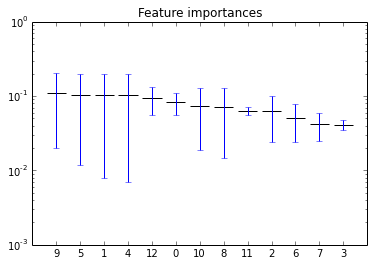

In [62]:
importances = plot_forest_feature_importances(model,X.columns)

# Формат вывода
<имя участника>,<балл>

То, что имя участника - файл - спишем на первое приближение ^_^

Алсо по яндексячей традиции хотелось бы отображать эту метрику как "попугаи" :)

In [75]:
with open("example_output.txt",'w') as fout:
    for k,v in importances.items():
        fout.write( '%s,%i\n'%( k, int(v*10**9)))

In [76]:
!head example_output.txt

6.csv,41836517
10.csv,62623851
2.csv,41300017
submission2.csv,93154208
7.csv,72030730
submission1.csv,63086311
3.csv,102473459
submission.csv,72528485
9.csv,111186564
4.csv,103206561
